In [1]:
import syft as sy

# Part 1: Join the Duet Server the Data Owner connected to

In [2]:
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


/home/user-010/anaconda3/envs/pysyft/lib/python3.7/site-packages/aiortc/rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
/home/user-010/anaconda3/envs/pysyft/lib/python3.7/site-packages/aiortc/rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until Checkpoint 1.

# Part 2: Search for Available Data


In [3]:
# The data scientist can check the list of pointable data in Data Owner's duet store
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 0e3419be89044758b740b812bcd507df>,[Crops-data],This is a dataset for Crops classification tem...,<class 'torch.Tensor'>
1,<UID: fed555467b904e7e85f501973e02ab65>,[Crops-target],"Labels for Crops: rice, maize, chickpea",<class 'torch.Tensor'>


In [4]:
# Data Scientist wants to get the crop dataset. (S)He needs a pointer to the data and
# a pointer to the target for prediction.
data_ptr = duet.store[0]
target_ptr = duet.store[1]

# data_ptr.requires_grad = True
# target_ptr.requires_grad = True

# data_ptr is a reference to the crop dataset remotely available on data owner's server
# target_ptr is a reference to the crop dataset LABELS
# remotely available on data owner's server
print(data_ptr)
print(target_ptr)

# Part 3: Perform Logistic Regression on Crop dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to explicitly shared by the Data Owner. Let's try to find them in the data description.

In [5]:
print(duet.store.pandas["Description"][0])

print(duet.store.pandas["Description"][1])

This is a dataset for Crops classification temperature, humidity, Ph level, Rainfall
Labels for Crops: rice, maize, chickpea


### Train model

In [6]:
import torch
#import xgboost as xgb
import time
from sklearn.metrics import mean_squared_error

In [7]:
in_dim = 4
out_dim = 3
n_samples = 150

In [8]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)
        #self.flatten = self.torch_ref.nn.Flatten()
    def forward(self, X111):
        X111 = self.torch_ref.nn.functional.relu(self.layer1(X111))
        X111 = self.torch_ref.nn.functional.relu(self.layer2(X111))
        output = self.torch_ref.nn.functional.log_softmax(self.out(X111), dim=1)
        
        #self.torch_ref.nn.Flatten(x)
        return output


local_model = SyNet(torch)

In [9]:
remote_model = local_model.send(duet)

Let's create an alias for our partner’s torch called remote_torch so we can refer to the local torch as torch and any operation we want to do remotely as remote_torch. Remember, the return values from remote_torch are Pointers, not the real objects. They mostly act the same when using them with other Pointers but you can't mix them with local torch objects.

In [10]:
remote_torch = duet.torch

In [11]:
#remote_torch

In [12]:

params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)

In [13]:
print(remote_model.parameters())

In [14]:
print(optim)

In [15]:
start_time = time.time()
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        
        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses
print("Computational time :- %s seconds " % (time.time() - start_time))

Computational time :- 0.00028443336486816406 seconds 


In [16]:
iteration = 300
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 1.1230518817901611
Epoch 10 loss 0.8002332448959351
Epoch 20 loss 0.6343919634819031
Epoch 30 loss 0.6042685508728027
Epoch 40 loss 0.5841200351715088
Epoch 50 loss 0.5639989376068115
Epoch 60 loss 0.5423066020011902
Epoch 70 loss 0.5190867781639099
Epoch 80 loss 0.4907661974430084
Epoch 90 loss 0.45858851075172424
Epoch 100 loss 0.42385533452033997
Epoch 110 loss 0.38672149181365967
Epoch 120 loss 0.3478432595729828
Epoch 130 loss 0.31034839153289795
Epoch 140 loss 0.2751479744911194
Epoch 150 loss 0.24535807967185974
Epoch 160 loss 0.21897435188293457
Epoch 170 loss 0.1976703554391861
Epoch 180 loss 0.1780061423778534
Epoch 190 loss 0.1613348424434662
Epoch 200 loss 0.14589852094650269
Epoch 210 loss 0.13277161121368408
Epoch 220 loss 0.12088719755411148
Epoch 230 loss 0.11048797518014908
Epoch 240 loss 0.09993624687194824
Epoch 250 loss 0.0903189405798912
Epoch 260 loss 0.08113979548215866
Epoch 270 loss 0.07306986302137375
Epoch 280 loss 0.0663987547159195
Epoch 290 lo

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epoch')

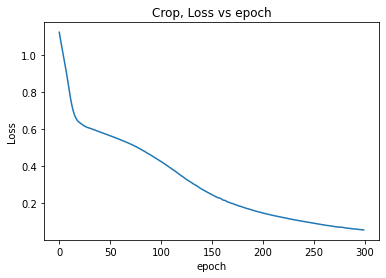

In [18]:
plt.title('Crop, Loss vs epoch')
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("epoch")


### Download model

In [19]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

In [20]:
local_model

### Test on local data

In [21]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [22]:
crop_test = pd.read_csv(f"Crop_test_data_Artharva1.csv")

In [23]:
from sklearn.preprocessing import StandardScaler
df2 = StandardScaler().fit_transform(crop_test.iloc[:, 0:5])

In [24]:
df = pd.DataFrame(df2)

In [25]:
XX_test = df.loc[:, crop_test.columns != "label"]
yy_test = crop_test["label"]

In [26]:
XX_test

,0,1,2,3
0,-0.171131,0.988401,-0.165213,0.877023
1,0.152926,0.927490,0.572103,1.187286
2,0.458778,0.324544,-1.189264,-0.629555
3,-1.576593,-1.368635,1.186533,-0.619221
4,0.600780,1.000003,1.664423,1.675177
5,1.871522,0.921689,0.490179,1.399185
6,1.729519,0.610245,0.421909,-0.439761
7,0.804682,0.610970,0.053251,-0.904762
8,-0.848375,-1.363559,0.408255,-0.731973
9,-1.259818,-1.425920,-0.847914,-0.880825


In [27]:
yy_test

0     0
1     0
2     1
3     2
4     0
5     0
6     1
7     1
8     2
9     2
10    0
11    0
12    0
13    1
14    1
15    1
16    0
17    0
18    0
19    2
20    2
21    2
22    1
23    1
24    1
25    1
26    2
27    2
28    2
29    2
Name: label, dtype: int64

In [28]:
XX1_test = torch.FloatTensor(np.array(XX_test))
yy1_test = torch.LongTensor(np.array(yy_test))

In [29]:
preds = []
with torch.no_grad():
    #local_model.eval()
    for i in range(len(XX1_test)):
        sample = XX1_test[i]
       
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {yy1_test[i]}")
        preds.append(pred)

Prediction: 2 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 1
Prediction: 2 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2


In [30]:
#preds = []
#with torch.no_grad():
  #  #local_model.eval()
   # for i in range(len(XX1_test)):
    #    sample = XX1_test[i]
       
     #   y_hat = local_model(sample.unsqueeze(0))
      #  pred = y_hat.argmax().item()
       # print(f"Prediction: {pred} Ground Truth: {yy1_test[i]}")
        #preds.append(pred)
#preds = [sample.squeeze().tolist() for sample in preds]

In [31]:
sample

tensor([-1.2161, -1.3208,  2.9069, -0.7050])

In [32]:
y_hat

tensor([[-1.6114e+01, -9.6993e+01, -1.1921e-07]])

In [33]:
acc = accuracy_score(yy1_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 73.33333333333333


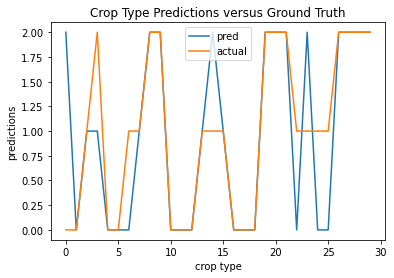

In [34]:
plt.title('Crop Type Predictions versus Ground Truth')

plt.plot(preds, label='pred')
plt.plot(yy1_test, label='actual')
plt.legend()
plt.xlabel('crop type')
plt.ylabel('predictions')
plt.show()

In [35]:
#plt.title('Crop Type Predictions versus Ground Truth')

#plt.scatter(preds, range(len(preds)), label='pred')
#plt.scatter(yy1_test, range(len(yy1_test)), label='actual')
#plt.legend()
#plt.xlabel('crop type')
#plt.ylabel('predictions')
#plt.show()

In [36]:
#print("Base Model parameters:")
print(remote_model)
print()

#print("Remote model1 parameters:")
#print(remote_torch)
print()

#print("Remote model2 parameters:")
#print(param2)

In [37]:
#y_pred_list = []
#model.eval()
#with torch.no_grad():
#    for X_batch in test_loader:
#        X_batch = X_batch.to(device)
#        y_test_pred = model(X_batch)
#        y_test_pred = torch.sigmoid(y_test_pred)
#        y_pred_tag = torch.round(y_test_pred)
#        y_pred_list.append(y_pred_tag.cpu().numpy())

#y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [38]:
from sklearn.metrics import classification_report

print(classification_report(yy1_test, preds))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.80      0.40      0.53        10
           2       0.75      0.90      0.82        10

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.71        30
weighted avg       0.75      0.73      0.71        30



In [ ]:
#to check the classical machine training results

In [ ]:
#Comparison to classical linear regression on centralised data
import torch
import numpy as np

in_dim = 1
out_dim = 1


class ClassicalLR(torch.nn.Module):
    def __init__(self, torch):
        super(ClassicalLR, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.linear(x)
        return x


classical_model = ClassicalLR(torch)

In [ ]:
data = torch.FloatTensor(
    np.array([5, 15, 25, 35, 45, 55, 60, 65, 75, 85, 95]).reshape(-1, 1)
)
target = torch.FloatTensor(
    np.array([5, 10, 15, 22, 30, 38, 35, 40, 45, 55, 60]).reshape(-1, 1)
)

In [ ]:
def classic_train(iterations, model, torch, optim, data, target, criterion):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss_item = loss.item()

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_item)

        losses.append(loss_item)

        loss.backward()

        optim.step()

    return losses

In [ ]:
params = classical_model.parameters()
optim = torch.optim.Adam(params=params, lr=0.1)
criterion = torch.nn.MSELoss()

In [ ]:
iteration = 100
losses = classic_train(
    iteration, classical_model, torch, optim, data, target, criterion
)

In [ ]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [ ]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = classical_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)